In [313]:
#imports
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy import units
import getdata
import densities
from scipy.optimize import curve_fit

from galpy.potential import TwoPowerSphericalPotential
from galpy.potential import HernquistPotential
from galpy.potential import PlummerPotential
from galpy.potential import DehnenSphericalPotential
from galpy.potential import DehnenCoreSphericalPotential
from galpy.potential import JaffePotential
from galpy.potential import NFWPotential
from galpy.potential import PowerSphericalPotential
from galpy.potential import PowerSphericalPotentialwCutoff
from galpy.potential import PseudoIsothermalPotential

In [314]:
def getdensityprofile(nr_bins = 100, bin_distr = "adaptive"):
    bin_distr_options = ["linear", "logarithmic", "adaptive"]
    coords = getdata.coordskpc()
    mass = getdata.masssolar()
    
    if(bin_distr not in bin_distr_options):
        print(f"Error: bin_distr contains no valid distribution type. Choose from: " + str(bin_distr_options) + ", performing linear distribution instead.")
        bin_distr = "linear"

    if((nr_bins <= 1) or (isinstance(nr_bins, int) == False)):
        print(f"Error: bin amount must be a positive integer. Will now default to 1000 bins.")
        nr_bins = 1000

    coord_com = np.sum(coords,axis=0) / len(coords)
    coords_centred = coords - coord_com
    com_dist = np.sqrt(np.sum(coords_centred**2, axis=1))

    r_min = np.min(com_dist)
    r_max = np.max(com_dist)
    bins = np.linspace(r_min, r_max, nr_bins) 
    
    if(bin_distr == "adaptive"):
        com_dist_sorted = np.sort(com_dist)
        nr_particles = len(com_dist_sorted)

        bin_size = nr_particles // nr_bins
        bin_limit = nr_bins*bin_size
        bins = com_dist_sorted[:bin_limit].reshape(nr_bins, bin_size)

        bin_inner_bound = bins[:, 0]         
        bin_outer_bound = bins[:, -1]       
        bin_centre = np.mean(bins, axis=1)  

        bin_volume = (4/3)*np.pi*(bin_outer_bound**3 - bin_inner_bound**3)
        bin_density = bin_size*mass / bin_volume
        bin_poisson_error = np.sqrt(bin_size)*mass / bin_volume
        return bin_centre, bin_density, bin_poisson_error
        
    if(bin_distr == "linear"):
        bins = np.linspace(r_min, r_max, nr_bins)
    if(bin_distr == "logarithmic"):
        bins = np.logspace(np.log10(r_min.value), np.log10(r_max.value), nr_bins) * r_min.unit
    
    bin_counts, bin_edges = np.histogram(com_dist, bins=bins)
    bin_inner_bound = bin_edges[:-1]
    bin_outer_bound = bin_edges[1:]
    bin_centre = (bin_outer_bound + bin_inner_bound) / 2
    
    bin_volume = (4/3)*np.pi*(bin_outer_bound**3 - bin_inner_bound**3)
    bin_density = bin_counts*mass / bin_volume 
    bin_poisson_error = bin_density / np.sqrt(bin_counts)

    #remove zero density points to avoid logarithmic errors and fit errors
    nonzero_indices = [i for i, density in enumerate(bin_density) if density > 0.0]

    bin_density = [bin_density[i] for i in nonzero_indices] * bin_density.unit
    bin_centre = [bin_centre[i] for i in nonzero_indices] * bin_centre.unit
    bin_poisson_error = [bin_poisson_error[i] for i in nonzero_indices] * bin_poisson_error.unit

    return bin_centre, bin_density, bin_poisson_error

In [369]:
def calcpotentialdensity(bin_radius, potential_name, inputislog, *params):
    r_kpc = bin_radius
    if (inputislog == True):
        r_kpc = 10**bin_radius
    
    r_kpc = r_kpc * units.kpc

    #first 2 parameters are always mass and length scales
    total_mass =  (getdata.masssolar() * len(getdata.coordskpc())) 
    mscale = total_mass
    lscale = params[0] * units.kpc

    #make potential name lowercase, otherwise casesensitive
    potential_name = potential_name.lower()
    
    if (potential_name == "doublepowerlaw"):
        potential = TwoPowerSphericalPotential(amp=mscale, a=lscale, alpha=params[1], beta=params[2])
    elif (potential_name == "hernquist"):
        potential = HernquistPotential(amp=mscale, a=lscale)
    elif (potential_name == "plummer"):
        potential = PlummerPotential(amp=mscale, b=lscale)
    elif (potential_name == "dehnenspherical"):
        potential = DehnenSphericalPotential(amp=mscale, a=lscale, alpha=params[1])
    elif (potential_name == "dehnencorespherical"):
        potential = DehnenCoreSphericalPotential(amp=mscale, a=lscale)
    elif (potential_name == "jaffe"):
        potential = JaffePotential(amp=mscale, a=lscale)
    elif (potential_name == "nfw"):
        potential = NFWPotential(amp=mscale, a=lscale)
    elif (potential_name == "powerspherical"):
        potential = PowerSphericalPotential(amp=mscale, alpha=params[1], normalize=False, r1=lscale)
    elif (potential_name == "powersphericalwcutoff"):
        potential = PowerSphericalPotentialwCutoff(amp=params[1]*(units.Msun / units.kpc**3), alpha=params[2], rc=params[3]*units.kpc, normalize=False, r1=lscale)
    elif (potential_name == "pseudoisothermal"):
        potential = PseudoIsothermalPotential(amp=mscale, a=lscale)
    else:
        raise ValueError(f"Unknown potential: {potential_name}")

    density = potential.dens(r_kpc, z=0*units.kpc, phi=0, t=0, forcepoisson=False).to("solMass/kpc3")
    if (inputislog == True):
        return np.log10(density.value)
    else:
        return density.value

In [323]:
def show_fitparameters_errors(param, bdensity, fitdensity, potentialname):
    bindensity_log = np.log10(bdensity)
    fitdensity_log = np.log10(fitdensity)
    
    residuals = bindensity_log - fitdensity_log         
    rms_error = np.sqrt(np.mean(residuals**2))                          
    
    squaresum_residual = np.sum(residuals**2)
    squaresum_total = np.sum((bindensity_log - np.mean(bindensity_log))**2)
    rsquared_error = 1.0 - (squaresum_residual / squaresum_total)            #relative error

    print("RMSE of " + potentialname + " fit: " + str(rms_error))
    print("RSQUARED of " + potentialname + " fit: " + str(rsquared_error))   #RSQUARED of 1 is best.

In [362]:
def getbestfit(nr_bins=80, bin_distr="adaptive", potential_name="doublepowerlaw"):
    bin_radius, bin_density, bin_poisson_error = getdensityprofile(nr_bins=nr_bins, bin_distr=bin_distr)
    potential_name = potential_name.lower()

    # Log-space setup
    bin_radius_log = np.log10(bin_radius.value)
    bin_density_log = np.log10(bin_density.value)
    inputislog = True

    # Initial parameter guesses
    
    bin_radius_average = sum(bin_radius) / len(bin_radius)
    total_mass =  (getdata.masssolar() * len(getdata.coordskpc())) 
    params = [bin_radius_average.value]

    # Add extra parameters if needed
    if (potential_name == "doublepowerlaw"):
        #alpha, beta
        params += [1.5, 3.5]
    if (potential_name == "dehnenspherical"):
        #alpha
        params += [1.5]
    if (potential_name == "powerspherical"):
        #alpha
        params += [1.5]
    if (potential_name == "powersphericalwcutoff"):
        #density, alpha, rcuttoff
        params += [15.0, 1.5, 10.0]
    
    total_mass =  (getdata.masssolar() * len(getdata.coordskpc())) 
    
    # black magic function to avoid scipy.logfit error (needs r_log as first input)
    def model_for_fit(r_log, *fit_params):
        return calcpotentialdensity(r_log, potential_name, inputislog, *fit_params)
        
    #loglog fit
    popt, pcov = curve_fit(model_for_fit, bin_radius_log, bin_density_log, p0=params)

    params = list(popt)
    print("optimal parameters for " + potential_name + " with mass " + str(total_mass.to("GsolMass")) + ", lengthscale: " + str(params[0]*units.kpc) + ", and other parameters: " + str(params[1:]))
    return params

In [363]:
def plotpotentialdensityfit(nr_bins = 40, bin_distr = "adaptive", potential_name = "doublepowerlaw"):
    bin_radius, bin_density, bin_poisson_error = getdensityprofile(nr_bins=nr_bins, bin_distr=bin_distr)
    fit_parameters = getbestfit(nr_bins=nr_bins, bin_distr=bin_distr, potential_name=potential_name)
    inputislog = False
    
    fit_density = (calcpotentialdensity(bin_radius.value, potential_name, inputislog, *fit_parameters)) * units.Msun / (units.kpc**3)
    show_fitparameters_errors(fit_parameters, bin_density.value, fit_density.value, potential_name)
    
    fig, axs = plt.subplots(2, sharex=False, sharey=False)

    axs[0].scatter(bin_radius, bin_density, s=1, label="data")
    axs[0].plot(bin_radius, fit_density, c="red", label="galpy fit")
    axs[0].set_xscale("log")
    axs[0].set_yscale("log")
        
    axs[1].scatter(bin_radius, bin_density, s=1, label="data")
    axs[1].plot(bin_radius, fit_density, c="red", label="galpy fit")
    axs[1].set_xscale("linear")
    axs[1].set_yscale("linear")
    
    fig.supxlabel("Radius (" + str(bin_radius.unit) + ")") 
    fig.supylabel("Density (" + str(bin_density.unit) + ")") 
        
    plt.suptitle("Best fit of " + potential_name)
    plt.legend()
    plt.tight_layout()
    plt.show()

C:\Users\niels\anaconda3\envs\tana2025\Lib\site-packages\galpy\potential\TwoPowerSphericalPotential.py:170: RuntimeWarning: invalid value encountered in power
  (self.a / r) ** self.alpha

C:\Users\niels\anaconda3\envs\tana2025\Lib\site-packages\galpy\potential\TwoPowerSphericalPotential.py:171: RuntimeWarning: invalid value encountered in power
  / (1.0 + r / self.a) ** (self.beta - self.alpha)

optimal parameters for doublepowerlaw with mass 161.47893455855902 GsolMass, lengthscale: 4.573985216477695 kpc, and other parameters: [np.float64(0.32540726415465004), np.float64(3.934193122563397)]
RMSE of doublepowerlaw fit: 0.5033529692999716
RSQUARED of doublepowerlaw fit: 0.9451408928830866


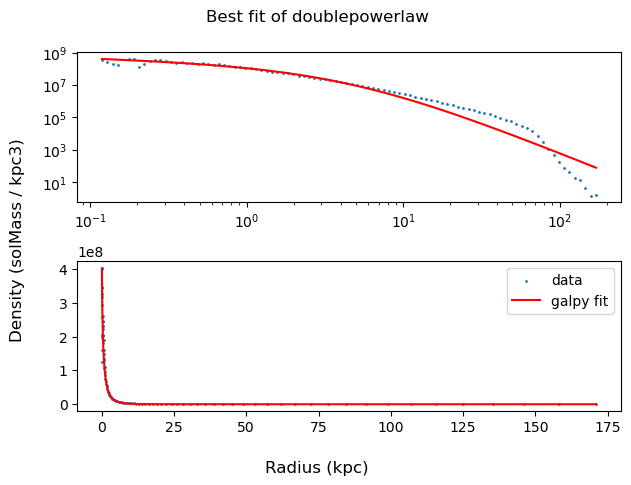

In [364]:
plotpotentialdensityfit(nr_bins = 100, bin_distr = "logarithmic", potential_name = "doublepowerlaw")

C:\Users\niels\anaconda3\envs\tana2025\Lib\site-packages\astropy\units\quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)

optimal parameters for hernquist with mass 161.47893455855902 GsolMass, lengthscale: 9.885951693842856 kpc, and other parameters: []
RMSE of hernquist fit: 0.5327263617165864
RSQUARED of hernquist fit: 0.9385514214083647


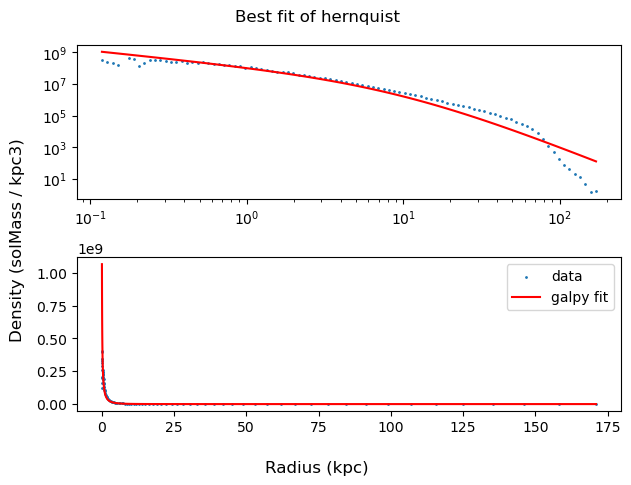

In [365]:
plotpotentialdensityfit(nr_bins = 100, bin_distr = "logarithmic", potential_name = "hernquist")

C:\Users\niels\anaconda3\envs\tana2025\Lib\site-packages\astropy\units\quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)

optimal parameters for plummer with mass 161.47893455855902 GsolMass, lengthscale: -7.35989253917216 kpc, and other parameters: []
RMSE of plummer fit: 0.4936003225128475
RSQUARED of plummer fit: 0.9472461288073492


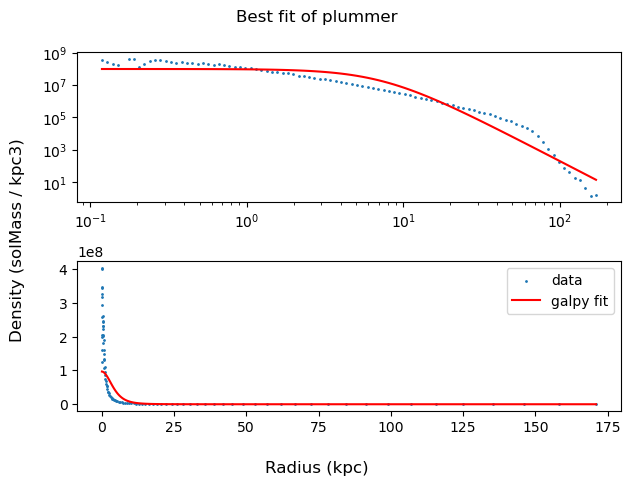

In [353]:
plotpotentialdensityfit(nr_bins = 100, bin_distr = "logarithmic", potential_name = "plummer")

C:\Users\niels\anaconda3\envs\tana2025\Lib\site-packages\astropy\units\quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)

C:\Users\niels\anaconda3\envs\tana2025\Lib\site-packages\galpy\potential\TwoPowerSphericalPotential.py:416: RuntimeWarning: invalid value encountered in power
  (self.a / r) ** self.alpha

C:\Users\niels\anaconda3\envs\tana2025\Lib\site-packages\galpy\potential\TwoPowerSphericalPotential.py:417: RuntimeWarning: invalid value encountered in power
  / (1.0 + r / self.a) ** (4.0 - self.alpha)

optimal parameters for dehnenspherical with mass 161.47893455855902 GsolMass, lengthscale: 5.256170771632842 kpc, and other parameters: [np.float64(0.4565591375353414)]
RMSE of dehnenspherical fit: 0.5040805538099105
RSQUARED of dehnenspherical fit: 0.9449821832426429


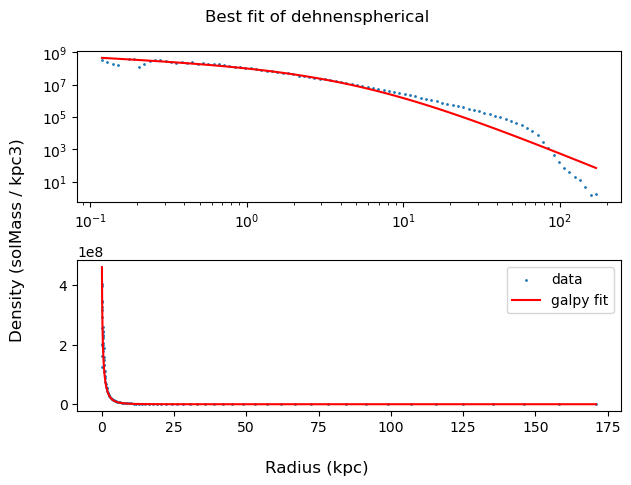

In [354]:
plotpotentialdensityfit(nr_bins = 100, bin_distr = "logarithmic", potential_name = "dehnenspherical")

C:\Users\niels\anaconda3\envs\tana2025\Lib\site-packages\astropy\units\quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)

C:\Users\niels\AppData\Local\Temp\ipykernel_20816\3548090101.py:41: RuntimeWarning: invalid value encountered in log10
  return np.log10(density.value)

C:\Users\niels\AppData\Local\Temp\ipykernel_20816\3548090101.py:41: RuntimeWarning: invalid value encountered in log10
  return np.log10(density.value)

optimal parameters for dehnencorespherical with mass 161.47893455855902 GsolMass, lengthscale: 3.501621545718235 kpc, and other parameters: []
RMSE of dehnencorespherical fit: 0.5172099584431981
RSQUARED of dehnencorespherical fit: 0.9420788439255307


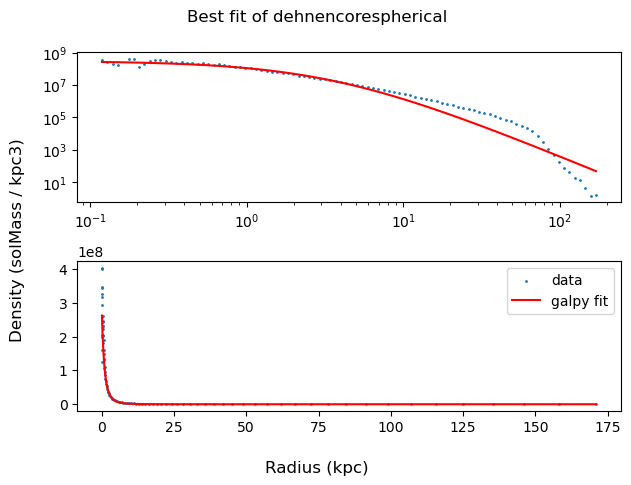

In [355]:
plotpotentialdensityfit(nr_bins = 100, bin_distr = "logarithmic", potential_name = "dehnencorespherical")

C:\Users\niels\anaconda3\envs\tana2025\Lib\site-packages\astropy\units\quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)

optimal parameters for jaffe with mass 161.47893455855902 GsolMass, lengthscale: 120.01128413589744 kpc, and other parameters: []
RMSE of jaffe fit: 0.7998962270192712
RSQUARED of jaffe fit: 0.8614614105096248


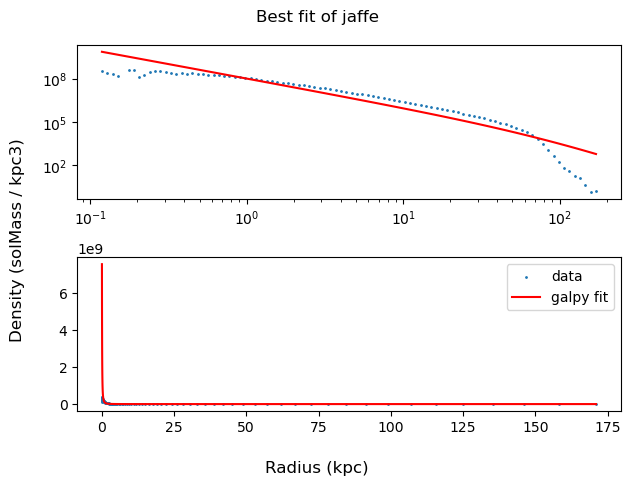

In [356]:
plotpotentialdensityfit(nr_bins = 100, bin_distr = "logarithmic", potential_name = "jaffe")

C:\Users\niels\anaconda3\envs\tana2025\Lib\site-packages\astropy\units\quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)

optimal parameters for nfw with mass 161.47893455855902 GsolMass, lengthscale: 12.608417556414633 kpc, and other parameters: []
RMSE of nfw fit: 0.7940130950207714
RSQUARED of nfw fit: 0.8620471600849975


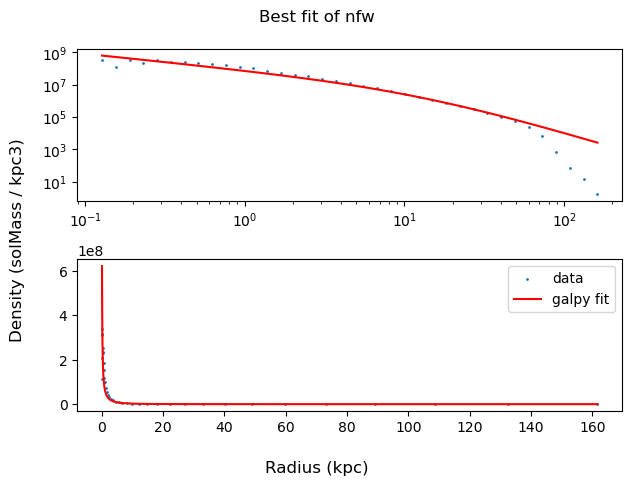

In [357]:
plotpotentialdensityfit(nr_bins = 40, bin_distr = "logarithmic", potential_name = "nfw")

C:\Users\niels\anaconda3\envs\tana2025\Lib\site-packages\astropy\units\quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)

optimal parameters for powerspherical with mass 161.47893455855902 GsolMass, lengthscale: 6611.893453615661 kpc, and other parameters: [np.float64(2.1089862692282084)]
RMSE of powerspherical fit: 0.896471290802937
RSQUARED of powerspherical fit: 0.8241476860274453


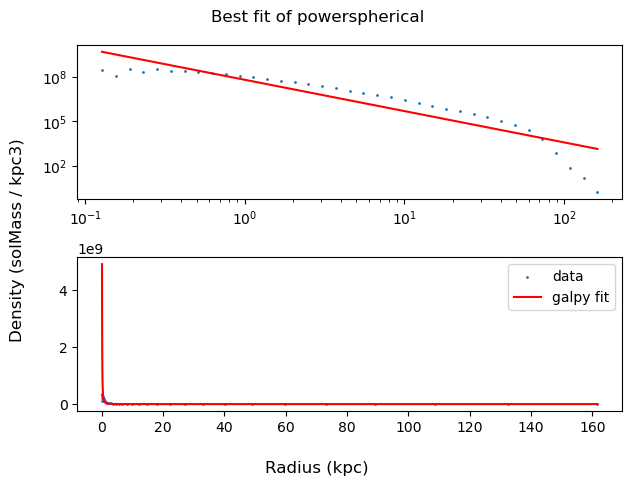

In [358]:
plotpotentialdensityfit(nr_bins = 40, bin_distr = "logarithmic", potential_name = "powerspherical")

C:\Users\niels\anaconda3\envs\tana2025\Lib\site-packages\astropy\units\quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)

C:\Users\niels\AppData\Local\Temp\ipykernel_20816\743650313.py:41: RuntimeWarning: invalid value encountered in log10
  return np.log10(density.value)

C:\Users\niels\AppData\Local\Temp\ipykernel_20816\743650313.py:41: RuntimeWarning: invalid value encountered in log10
  return np.log10(density.value)

C:\Users\niels\AppData\Local\Temp\ipykernel_20816\743650313.py:41: RuntimeWarning: invalid value encountered in log10
  return np.log10(density.value)

C:\Users\niels\AppData\Local\Temp\ipykernel_20816\743650313.py:41: RuntimeWarning: invalid value encountered in log10
  return np.log10(density.value)

C:\Users\niels\AppData\Local\Temp\ipykernel_20816\743650313.py:41: RuntimeWarning: invalid value encountered in log10
  return np.log10(density.value)

C:\Users\niels\AppData\Loca

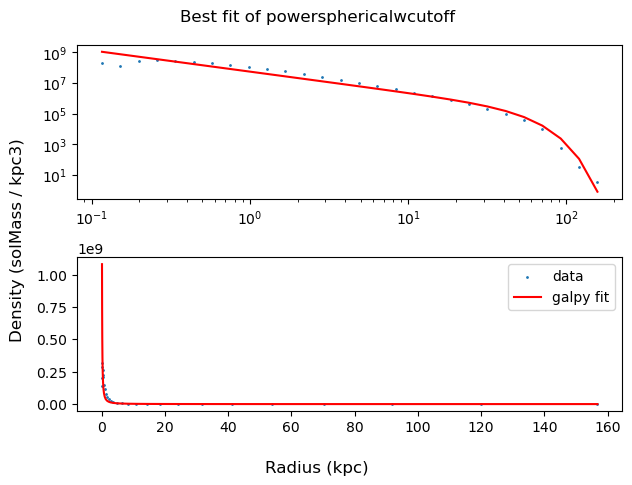

In [371]:
plotpotentialdensityfit(nr_bins = 30, bin_distr = "logarithmic", potential_name = "powersphericalwcutoff")

C:\Users\niels\anaconda3\envs\tana2025\Lib\site-packages\astropy\units\quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)

C:\Users\niels\AppData\Local\Temp\ipykernel_20816\743650313.py:41: RuntimeWarning: invalid value encountered in log10
  return np.log10(density.value)

optimal parameters for pseudoisothermal with mass 161.47893455855902 GsolMass, lengthscale: 7.259920901144232 kpc, and other parameters: []
RMSE of pseudoisothermal fit: 1.3736258732905688
RSQUARED of pseudoisothermal fit: 0.5795285254122721


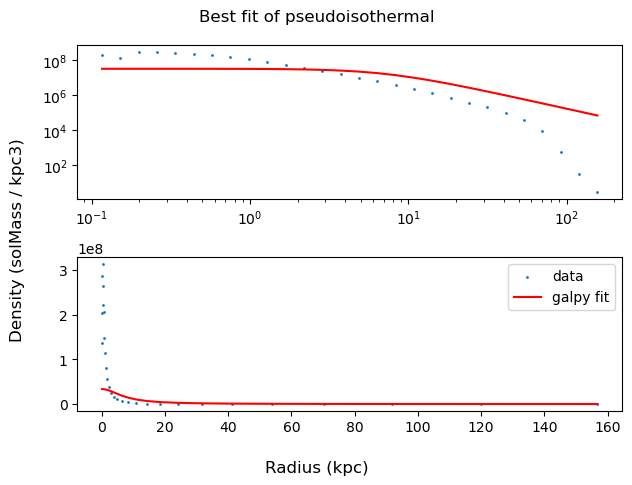

In [372]:
plotpotentialdensityfit(nr_bins = 30, bin_distr = "logarithmic", potential_name = "pseudoisothermal")